![netflix](http://pixel.nymag.com/imgs/daily/vulture/2019/02/13/13-netflix-film-ranking-update.w1100.h733.jpg)


<br>
Netflix held the Netflix Prize open competition for the best algorithm to predict user ratings for films.<br> The grand prize was $1,000,000 and it was won by a team after 3 years who made use of matrix factorization and achieved an improvement of over Netflix's own algorithm by 10.06 percent. <br> Let us have a look at this dataset and design a recommendation system.

In [1]:
#Importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
#Libraries for SVD
from scipy.sparse import csr_matrix
from surprise import Reader, Dataset, SVD, evaluate

In [2]:
#The data is distributed across 4 files, Due to memory constraint on kaggle let us work on a single file.
df = pd.read_csv('../input/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)

In [3]:
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


<b>The data basically consists of CustomerID,Rating and Date.</b>

MovieIDs ranges from 1 to 17770 sequentially.<br>
CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.<br>
Ratings are on a five star (integral) scale from 1 to 5.<br>
Dates have the format YYYY-MM-DD.

In [4]:
df.isna().sum()

Cust_Id       0
Rating     4499
dtype: int64

The null values are actually MovieIds and are sequentially arranged from 1 to 4499 in the first file and in total there are 17770 movie titles.

In [5]:
df.index = np.arange(0,len(df))
movies = df['Rating'].isna().sum()

#Let us look at the number of Users
users = df['Cust_Id'].nunique()-movies
print('There are {} number of Users'.format(users))

#Let us look at the number of reviews
reviews = df['Cust_Id'].count()-movies
print('There are {} number of Reviews'.format(reviews))

There are 470758 number of Users
There are 24053764 number of Reviews


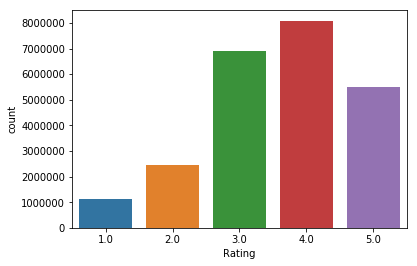

In [6]:
#Let us have a look at the distribution of ratings
sns.countplot(df['Rating'])
plt.show()

We can see most of the ratings are either 3 or 4.


<h3> Data cleaning </h3>

As seen earlier Movie Ids are customer Ids with Null ratings. Looping through the entire dataframe to extract this information would be inefficient. We can store this information in an array and later join it in the dataframe. 

In [7]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# For the last record
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

In [8]:
# Let us now remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

In [9]:
df.tail()

,Cust_Id,Rating,Movie_Id
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499
24058262,1704416,3.0,4499


We have extracted movie information and have stored it as an attribute. Let us try to get rid of data that might not be of much use for prediction.

<h3> Data reduction </h3>

<b> Due to the huge size of data it it causes out of memory errors.</b> <br> Let us remove movies which have not been reviewed much i.e they are not popular. <br> Users that not not active and have not given many ratingss

In [10]:
#Aggregation measures
f = ['count','mean']
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)

#Remove movies which have been reviewed much
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Minimum reviews: {}'.format(movie_benchmark))

Minimum reviews: 3884.0


In [11]:
#Similarly we can do this for Users who have not given much ratings
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 79.0


In [12]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))

Original Shape: (24053764, 3)
After Trim Shape: (13528427, 3)


We have almost reduced the size to half of the original dataset. <br>
This would help reducing the memory load. 

In [13]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
df_p.head()

Movie_Id,8,17,18,26,28,30,33,44,46,52,58,77,78,83,97,108,111,118,138,143,148,152,156,165,166,167,171,175,187,189,191,197,199,209,215,216,223,225,232,240,...,4302,4306,4310,4315,4330,4331,4339,4341,4345,4353,4355,4356,4360,4364,4369,4374,4380,4383,4384,4386,4389,4392,4393,4396,4402,4418,4420,4427,4429,4432,4454,4465,4472,4474,4479,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5.0,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,1.0,5.0,NaN,4.0,NaN,NaN,3.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,2.0,3.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,4.0,5.0,NaN,4.0,5.0,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,NaN,1.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,NaN,5.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,5.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By representing data in a matrix we can find correlations between users and their likings. We can find out similar users and by making use of collaborative filtering we can recommend movies they might like. <br>
Each cell in the matrix represents the associated opinion that a user holds. For instance, M_{i, j} denotes how user i likes item j. Such matrix is called utility matrix.

<b>Let us look at the titles datasets and later join it with the movie ids.</b>

In [14]:
#Movies titles dataset
df_title = pd.read_csv('../input/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


Let us make use of collaborative filtering to find movies that are related to each other. <br>
Collaborative Filtering does not require any information about the items or the users themselves. It recommends items based on users’ past behavior.

<b>There are two categories of CF</b>:

User-based: measure the similarity between target users and other users <br>
Item-based: measure the similarity between the items that target users rates/ interacts with and other items<br>
We are going to make use if item based CF and find movies which are related to each other. <br> <br>
In CF we fill the blank (cell) in the utility matrix that a user has not seen/rated before based on the similarity between users or items.

In [15]:
def recommend(movie_title, min_count):
    print("For movie {}".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [16]:
recommend("The Matrix: Reloaded", 0)

For movie The Matrix: Reloaded
- Top 10 movies recommended based on Pearsons'R correlation - 
PearsonR                               Name   count      mean
                                                             
1.000000               The Matrix: Reloaded  106807  3.514704
0.718287            The Matrix: Revolutions   60415  3.517040
0.342062                     Chain Reaction   15966  3.188150
0.334438                         Species II    7526  2.781424
0.331315                     Blade: Trinity   42727  3.548974
0.319057  Final Fantasy: The Spirits Within   17691  3.341303
0.318823   Superman IV: The Quest for Peace    7532  2.761020
0.311354                   X2: X-Men United   98720  3.932202
0.308881                    Men in Black II  136850  3.334731
0.308459                       The Avengers    4412  2.334769


In [17]:
recommend("Batman Begins", 0)

For movie Batman Begins
- Top 10 movies recommended based on Pearsons'R correlation - 
PearsonR                                               Name   count      mean
                                                                             
1.000000                                      Batman Begins   54922  4.236699
0.342535                                   X2: X-Men United   98720  3.932202
0.325859                                          Unleashed    8299  3.659718
0.299522                               The Bourne Supremacy  137170  3.909958
0.266266  Pirates of the Caribbean: The Curse of the Bla...  193941  4.153908
0.262317                               Smallville: Season 1   10082  4.169609
0.260591           Star Trek: The Next Generation: Season 5    8978  4.247494
0.258644                                 The Santa Clause 2    9368  3.627775
0.258229                                     Blade: Trinity   42727  3.548974
0.257741                                   The Last Sam

<h3> Singular Value Decomposition</h3>

With collaborative filtering there can be an issue of scalability and sparsity but this can be addressed using Singular value Decomposition.<br> <br>
Latent factor model to capture the similarity between users and items. We can view it as how good we are in predicting the rating for items given a user. <br>
SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r.<br> Therefore, it helps us better understand the relationship between users and items as they become directly comparable. 


In [18]:
#We make use of 3 folds and use RMSE and MAE as metrics
reader = Reader()
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/opt/conda/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/opt/conda/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9796
MAE:  0.7970
------------
Fold 2
RMSE: 0.9884
MAE:  0.7995
------------
Fold 3
RMSE: 0.9844
MAE:  0.7895
------------
------------
Mean RMSE: 0.9841
Mean MAE : 0.7953
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9796442986803952,
                             0.9883747669560088,
                             0.9843692225014224],
                            'mae': [0.7969942003456064,
                             0.799509440750627,
                             0.7894695571433272]})

Let us see what User 1663888 has liked in the past

In [27]:
df_1663888 = df[(df['Cust_Id'] == 1663888) & (df['Rating'] == 5)]
df_1663888 = df_1663888.set_index('Movie_Id')
df_1663888 = df_1663888.join(df_title)['Name']
print(df_1663888[:25])


Movie_Id
33                        Aqua Teen Hunger Force: Vol. 1
58                                           Dragonheart
83                                              Silkwood
97                                         Mostly Martha
143                                             The Game
165              Richard Pryor: Live on the Sunset Strip
240                                    Woman of the Year
241                                   North by Northwest
256                    Ghost Dog: The Way of the Samurai
311                                              Ed Wood
359                        Absolutely Fabulous: Series 5
420         Saturday Night Live: The Best of Dana Carvey
489                                   Return to Paradise
494    Monty Python's The Meaning of Life: Special Ed...
534                             With a Friend Like Harry
569                                          The In-Laws
580                            THX 1138: Special Edition
636                   

Now let us predict what would he like to watch based using SVD

In [29]:
user_1663888 = df_title.copy()
user_1663888 = user_1663888.reset_index()
user_1663888 = user_1663888[~user_1663888['Movie_Id'].isin(drop_movie_list)]

In [21]:
# getting the entire dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
trainset = data.build_full_trainset()
svd.fit(trainset)

In [30]:
user_1663888['Estimate_Score'] = user_1663888['Movie_Id'].apply(lambda x: svd.predict(1663888, x).est)

user_1663888 = user_1663888.drop('Movie_Id', axis = 1)

user_1663888 = user_1663888.sort_values('Estimate_Score', ascending=False)

In [32]:
user_1663888.head(9)

,Year,Name,Estimate_Score
2847,1961.0,The Hustler,5.0
3223,1930.0,All Quiet on the Western Front,5.0
2429,1979.0,Alien: Collector's Edition,5.0
1624,1986.0,Aliens: Collector's Edition,5.0
3222,1929.0,Nosferatu: Original Version,5.0
2347,1976.0,The Omen,5.0
1831,1968.0,Rosemary's Baby,5.0
1174,1984.0,Repo Man,5.0
240,1959.0,North by Northwest,5.0


Hence we can see how we can leverage the power of statistics and build solutions that can predict what a user might like. 